将原来的py代码修改为notebook中实现，方便调试和数据可视化

In [1]:
#模块导入
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import sklearn.preprocessing as preprocessing
import numpy as np
from sklearn.ensemble import BaggingRegressor

import numpy as np
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve


from sklearn.ensemble import RandomForestRegressor


In [2]:
#函数方法

def enum_to_int(data_train,data_test,columns=[]):
    # 枚举变量转int数值
    for i in range(0, len(columns)):
        column_name = columns[i]
        column_le = LabelEncoder().fit(data_train[column_name])
        column_label = column_le.transform(data_train[column_name])
        data_train[column_name] = column_label
        if any(data_test):
            column_label = column_le.transform(data_test[column_name])
            data_test[column_name] = column_label
    return data_train,data_test

def show_destr(data,columns=[]):
    # 连续取值的观察
    fig = plt.figure()
    fig.set(alpha=0.2)  # 设定图表颜色alpha参数
    for i in range(0,len(columns)):
        fig.add_subplot(len(columns) * 100 + 10 + 1 + i)  # 最后一位编码从0开始，但是实际sbuplot需要从1开始
        column_name = columns[i]
        data[column_name].plot(kind='kde')
        plt.title(column_name)
    plt.show()
    plt.close()

def show_int(data,columns=[]):
    #显示离散型变量
    fig = plt.figure()
    fig.set(alpha=0.2)  # 设定图表颜色alpha参数
    for i in xrange(0, len(columns)):
        fig.add_subplot(len(columns) * 100 + 10 + 1 + i)  # 最后一位编码从0开始，但是实际sbuplot需要从1开始
        column_name = columns[i]
        data[column_name].value_counts().plot(kind='bar')
        plt.title(column_name)
    plt.show()
    plt.close()

def corr_destr_label(data,columns=[],label=''):
    fig = plt.figure()
    fig.set(alpha=0.2)  # 设定图表颜色alpha参数
    for i in range(0,len(columns)):
        column_name=columns[i]
        fig.add_subplot(len(columns)*100+10+1+i)
        label_value_set=data[label].value_counts().keys()
        for label_value in label_value_set:
            data[column_name][data[label] == label_value].plot(kind='kde')
        plt.xlabel("column")  # plots an axis lable
        plt.ylabel(u"密度")
        plt.title(u"密度分布"+column_name)
        plt.legend(str(label_value_set), loc='best')  # sets our legend for our graph.

    plt.show()


#mode=1时为100%模式，相关性更明显
def corr_int_label(data, columns=[], label='',mode=0):
    fig = plt.figure()
    fig.set(alpha=0.2)  # 设定图表颜色alpha参数
    for i in range(0, len(columns)):
        fig.add_subplot(len(columns) * 100 + 10 + 1 + i)
        column_name = columns[i]
        data[label]=data[label].apply(lambda x:int(x))
        value_set = data[label].value_counts().keys()
        print 'value_set', value_set

        # 对lable的每一个取值,依次过滤，value_counts中map的key为展示图内部的柱体含义描述
        value_counts = {}
        for label_value in value_set:
            value_counts.update(
                {'label_' + str(label_value): data[data[label] == label_value][column_name].value_counts()})

        df = pd.DataFrame(value_counts)
        #每列调整为100%，
        if mode==1:
            for index_name in df.index:
                df.loc[index_name].fillna(0,inplace=True)
                df.loc[index_name]=df.loc[index_name]*1.0/df.loc[index_name].sum()

        df.plot(kind='bar', stacked=True)

        # df.plot(kind='bar', stacked=True)
        plt.title(column_name)
        plt.xlabel(column_name + "_value")
        plt.ylabel(column_name + "_counts")
    plt.show()

def columns_dummies(data_train,data_test,columns=[]):
    for i in range(0,len(columns)):
        column_name=columns[i]
        dummies_column = pd.get_dummies(data_train[column_name], prefix=column_name)
        data_train = pd.concat([data_train, dummies_column], axis=1)
        data_train.drop([column_name], axis=1, inplace=True)
        if any(data_test):
            dummies_column = pd.get_dummies(data_test[column_name], prefix=column_name)
            data_test = pd.concat([data_test, dummies_column], axis=1)
            data_test.drop([column_name], axis=1, inplace=True)
    return data_train,data_test

def set_missing_ages(data,columns=[],label='',algo=None):
    '''使用data数据columns中的维度来填充label字段有缺失的信息,算法为algo'''

    # 把已有的数值型特征取出来丢进Random Forest Regressor中
    data_tmp=data[columns+[label]]

    data_train=data_tmp.loc[data_tmp[label].notnull()]
    data_test=data_tmp.loc[data_tmp[label].isnull()]
    # print data_tmp[label].isnull()
    train_x=data_train[columns]
    train_y=data_train[label]
    test_x=data_test[columns]
    algo.fit(train_x,train_y)
    test_y=algo.predict(test_x)
    data.loc[(data[label].isnull()),label]=test_y
    return data,algo

    # # 乘客分成已知年龄和未知年龄两部分
    # known_age = age_df[age_df.Age.notnull()].as_matrix()
    # unknown_age = age_df[age_df.Age.isnull()].as_matrix()
    #
    # # y即目标年龄
    # y = known_age[:, 0]
    #
    # # X即特征属性值
    # X = known_age[:, 1:]
    #
    # # fit到RandomForestRegressor之中
    # rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    # rfr.fit(X, y)
    #
    # # 用得到的模型进行未知年龄结果预测
    # predictedAges = rfr.predict(unknown_age[:, 1::])
    #
    # # 用得到的预测结果填补原缺失数据
    # df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges
    #
    # return df, rfr



# 用sklearn的learning_curve得到training_score和cv_score，使用matplotlib画出learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,
                        train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
    """
    画出data在某模型上的learning curve.
    参数解释
    ----------
    estimator : 你用的分类器。
    title : 表格的标题。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
    n_jobs : 并行的的任务数(默认1)
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    if plot:
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel(u"训练样本数")
        plt.ylabel(u"得分")
        plt.gca().invert_yaxis()
        plt.grid()

        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std,
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"训练集上得分")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"交叉验证集上得分")

        plt.legend(loc="best")

        plt.draw()
        plt.gca().invert_yaxis()
        plt.show()

    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff

In [3]:
data_train = pd.read_csv('d:\\TDDOWNLOAD\\ML\\titanic\\officialData\\train.csv')
data_test=pd.read_csv('d:\\TDDOWNLOAD\\ML\\titanic\\officialData\\test.csv')

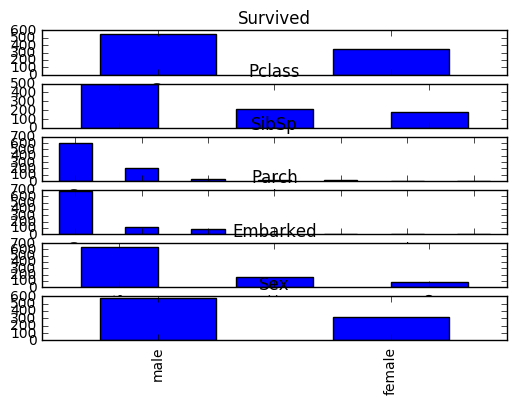

In [4]:
# 枚举转int,Embarked特征train有空导致dummy后特征数量和test不同，暂时注销
# columns = [ 'Embarked', 'Sex']
# data_train,data_test=enum_to_int(data_train,data_test,columns)
# print 'data_train',data_train.head()

#单属性显示
columns=['Survived','Pclass','SibSp','Parch','Embarked','Sex']
show_int(data_train,columns)

In [5]:
#缺失的属性处理
#cabin缺失过多，将是否缺失作为新的属性
data_train.loc[data_train['Cabin'].notnull(), 'Cabin' ] = "Yes"
data_train.loc[data_train['Cabin'].isnull(), 'Cabin' ] = "No"
data_test.loc[data_test['Cabin'].notnull(), 'Cabin' ] = "Yes"
data_test.loc[data_test['Cabin'].isnull(), 'Cabin' ] = "No"
#Age使用随机森林进行预测
data_train,algo=set_missing_ages(data_train, columns=['Fare', 'Parch', 'SibSp', 'Pclass'], label='Age', algo=RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1))
data_test_predict=algo.predict(data_test.loc[data_test['Age'].isnull()][['Fare', 'Parch', 'SibSp', 'Pclass']])
data_test.loc[data_test['Age'].isnull(),'Age']=data_test_predict

value_set Int64Index([0, 1], dtype='int64')
value_set Int64Index([0, 1], dtype='int64')


c:\python27\lib\site-packages\pandas\core\generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


value_set Int64Index([0, 1], dtype='int64')
value_set Int64Index([0, 1], dtype='int64')
value_set Int64Index([0, 1], dtype='int64')


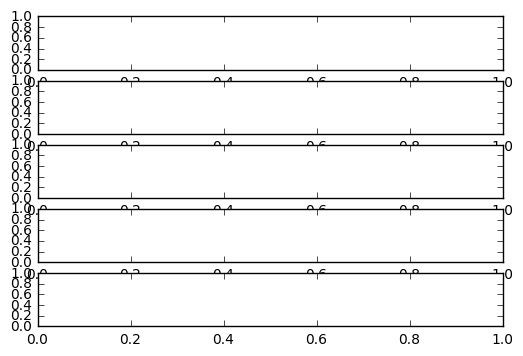

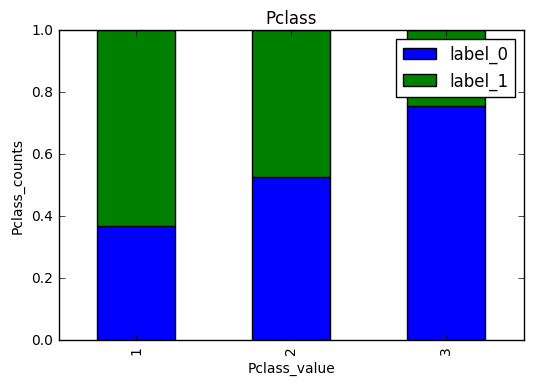

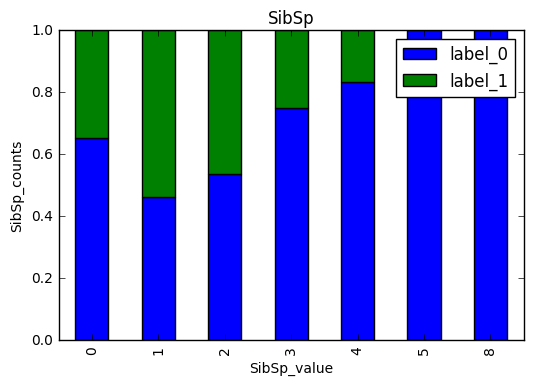

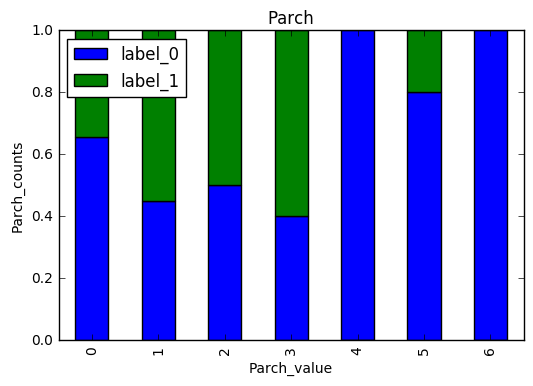

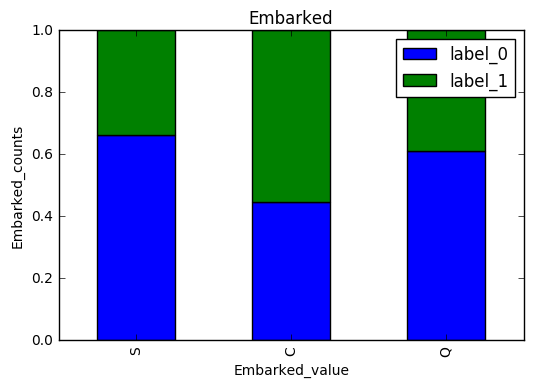

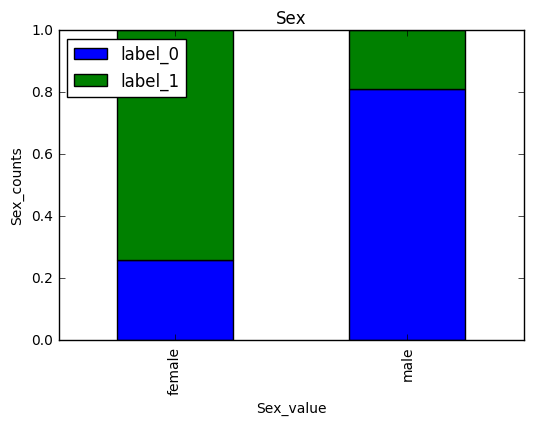

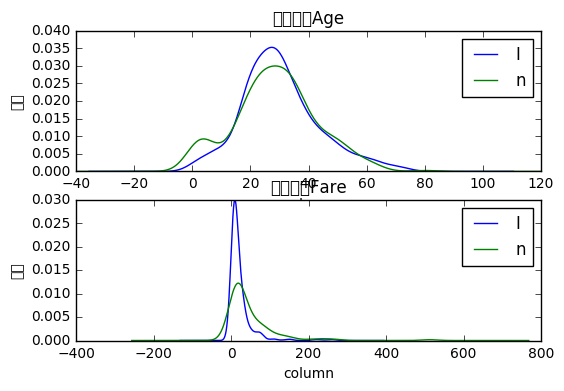

In [6]:
#属性和分类目标的相关性
columns=['Pclass','SibSp','Parch','Embarked','Sex']
label='Survived'
corr_int_label(data_train,columns,label,mode=1)

columns=['Age','Fare']
label='Survived'
corr_destr_label(data_train,columns,label)

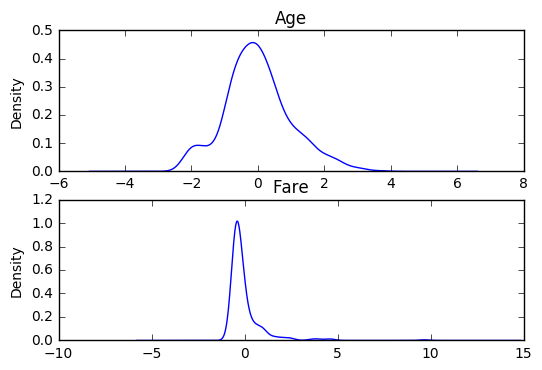

In [7]:
#特殊数据归一化
scaler = preprocessing.StandardScaler()
data_train['Age'].fillna(data_train['Age'].median(),inplace=True)
data_test['Age'].fillna(data_train['Age'].median(),inplace=True)
age_scale_param = scaler.fit(data_train['Age'].values.reshape(-1,1))
data_train['Age'] = scaler.fit_transform(data_train['Age'].values.reshape(-1,1), age_scale_param)
data_test['Age'] = scaler.fit_transform(data_test['Age'].values.reshape(-1,1), age_scale_param)

data_train['Fare'].fillna(data_train['Fare'].median(),inplace=True)
data_test['Fare'].fillna(data_train['Fare'].median(),inplace=True)
fare_scale_param = scaler.fit(data_train['Fare'].values.reshape(-1,1))
data_train['Fare'] = scaler.fit_transform(data_train['Fare'].values.reshape(-1,1), fare_scale_param)
data_test['Fare'] = scaler.fit_transform(data_test['Fare'].values.reshape(-1,1), fare_scale_param)

columns=['Age',"Fare"]
show_destr(data_train,columns)

In [8]:
columns=['Embarked','Sex','Pclass','Cabin']
data_train,data_test=columns_dummies(data_train,data_test,columns)
data_train=data_train.drop(['Ticket','Name'],axis=1)
data_test=data_test.drop(['Ticket','Name'],axis=1)
print data_train.head()

   PassengerId  Survived       Age  SibSp  Parch      Fare  Embarked_C  \
0            1         0 -0.561363      1      0 -0.502445           0   
1            2         1  0.613182      1      0  0.786845           1   
2            3         1 -0.267727      0      0 -0.488854           0   
3            4         1  0.392955      1      0  0.420730           0   
4            5         0  0.392955      0      0 -0.486337           0   

   Embarked_Q  Embarked_S  Sex_female  Sex_male  Pclass_1  Pclass_2  Pclass_3  \
0           0           1           0         1         0         0         1   
1           0           0           1         0         1         0         0   
2           0           1           1         0         0         0         1   
3           0           1           1         0         1         0         0   
4           0           1           0         1         0         0         1   

   Cabin_No  Cabin_Yes  
0         1          0  
1         0       

In [9]:
# 用正则取出我们要的属性值
train_df = data_train.filter(regex='Survived|Cabin_*|Age|SibSp|Parch|Fare_.*|Embarked_.*|Sex_.*|Pclass_.*')
test_df = data_test.filter(regex='Cabin_*|Age|SibSp|Parch|Fare_.*|Embarked_.*|Sex_.*|Pclass_.*')
print train_df.head()
train_np = train_df.as_matrix()
test_np=test_df.as_matrix()
print 'train_df.columns()',train_df.columns
print 'test_df.columns()',test_df.columns

   Survived       Age  SibSp  Parch  Embarked_C  Embarked_Q  Embarked_S  \
0         0 -0.561363      1      0           0           0           1   
1         1  0.613182      1      0           1           0           0   
2         1 -0.267727      0      0           0           0           1   
3         1  0.392955      1      0           0           0           1   
4         0  0.392955      0      0           0           0           1   

   Sex_female  Sex_male  Pclass_1  Pclass_2  Pclass_3  Cabin_No  Cabin_Yes  
0           0         1         0         0         1         1          0  
1           1         0         1         0         0         0          1  
2           1         0         0         0         1         1          0  
3           1         0         1         0         0         0          1  
4           0         1         0         0         1         1          0  
train_df.columns() Index([u'Survived', u'Age', u'SibSp', u'Parch', u'Embarked_C', u'Emb

In [10]:
from sklearn import linear_model

# y即Survival结果
y = train_np[:, 0]
# X即特征属性值
X = train_np[:, 1:]

# fit到RandomForestRegressor之中
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
# clf.fit(X, y)
bagging_clf = BaggingRegressor(clf, n_estimators=20, max_samples=0.8, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=-1)
bagging_clf.fit(X,y)
predictions = bagging_clf.predict(test_df)
result = pd.DataFrame({'PassengerId':data_test['PassengerId'].as_matrix(), 'Survived':predictions.astype(np.int32)})
result.to_csv("d:\\TDDOWNLOAD\\ML\\titanic\\officialData\\logistic_regression_predictions.csv", index=False)


In [11]:
# print list(train_df.columns)
# print pd.DataFrame({"columns":list(train_df.columns)[1:], "coef":list(clf.coef_.T)})

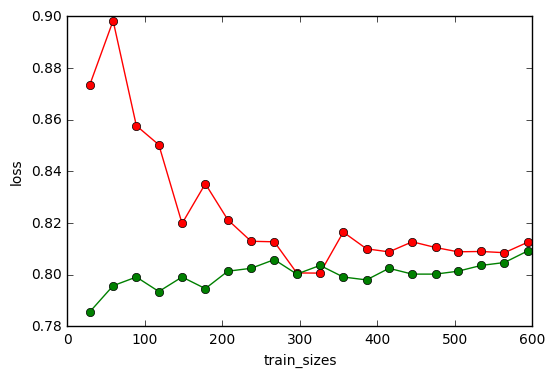

In [12]:
#判断是否过拟合
data_x=X
data_y=y
train_sizes,train_loss,test_loss=learning_curve(clf,data_x,data_y,train_sizes=np.linspace(0.05,1,20))

train_loss_mean=np.mean(train_loss,axis=1)
test_loss_mean=np.mean(test_loss,axis=1)

plt.plot(train_sizes,train_loss_mean,'o-',color='r',label='train_loss_mean')
plt.plot(train_sizes,test_loss_mean,'o-',color='g',label='test_loss_mean')
plt.xlabel('train_sizes')
plt.ylabel('loss')
plt.show()

从上图可以看出，并没有过拟合现象